In [1]:
#https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels
# Credit Card Fraud Detection
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_original = pd.read_csv('creditcard.csv')
df= df_original.copy()

In [3]:
#Standardize the time feature and amount feature.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit( np.array( df[ "Time"]).reshape(-1, 1) )
scaler.scale_, scaler.mean_

(array([47488.0625855]), array([94813.85957508]))

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit( np.array( df[ "Time"]).reshape(-1, 1) )
df["Time"]= scaler.transform( np.array( df[ "Time"]).reshape(-1, 1) )

In [5]:
scaler_amount = StandardScaler()
scaler.fit( np.array( df[ "Amount"]).reshape(-1, 1) )
df["Amount"]= scaler.transform( np.array( df[ "Amount"]).reshape(-1, 1) )

In [6]:
df["Class"]= df["Class"].apply( lambda x: 1 if x==1 else -1)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-1
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-1
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-1
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-1
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-1


In [8]:
#Check the missing data
missing_data= np.sum( df.isnull(), axis=0 )
missing_features=[ feature for feature in missing_data.index if missing_data[feature]>0 ]
missing_features

[]

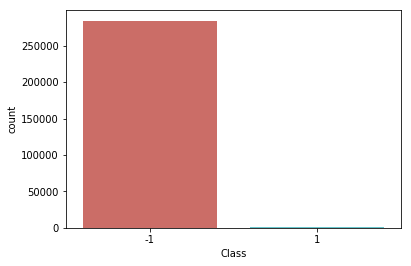

In [9]:
#unitary data analysis
#2.1. Data analysis: unitary data analysis
sns.countplot(x='Class',data=df, palette='hls')
plt.show()

In [10]:
num_fraud=np.sum( df["Class"]== 1 )
num_non_fraud=np.sum( df["Class"]== -1 )
print("fraction of fraud "+ str(num_fraud/ (num_non_fraud+ num_fraud)  ) )

fraction of fraud 0.001727485630620034


In [11]:
# train test split
X= df.loc[:, df.columns !='Class'];
y= df.loc[:, 'Class'];

X_train, X_tem, y_train, y_tem= train_test_split(X, y, test_size=0.5, random_state=0);
X_val, X_test, y_val, y_test= train_test_split(X_tem, y_tem, test_size=0.6, random_state=0);

In [12]:
len(X_train), len(X_val), len(X_test)

(142403, 56961, 85443)

In [13]:
#Make X_train, y_train balanced
os=SMOTE(random_state=0);
os_X_train, os_y_train= os.fit_sample(X_train, y_train);
os_X_train= pd.DataFrame( data= os_X_train, columns= X_train.columns );
os_y_train= pd.DataFrame( data= os_y_train, columns=['Class'] );


os_X_val, os_y_val= os.fit_sample(X_val, y_val);
os_X_val= pd.DataFrame( data= os_X_val, columns= X_val.columns );
os_y_val= pd.DataFrame( data= os_y_val, columns=['Class'] );

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_X_train))
print("Number of no subscription in oversampled data", sum(os_y_train['Class']==-1) );
print("Number of subscription",sum(os_y_train['Class']==1) );
print("Proportion of no subscription data in oversampled data is ",sum(os_y_train['Class']==-1)/len(os_X_train) )
print("Proportion of subscription data in oversampled data is ",sum(os_y_train['Class']==1)/len(os_X_train) )

print("length of oversampled data is ",len(os_X_val))
print("Number of no subscription in oversampled data", sum(os_y_val['Class']==-1) );
print("Number of subscription",sum(os_y_val['Class']==1) );
print("Proportion of no subscription data in oversampled data is ",sum(os_y_val['Class']==-1)/len(os_X_val) )
print("Proportion of subscription data in oversampled data is ",sum(os_y_val['Class']==1)/len(os_X_val) )

length of oversampled data is  284308
Number of no subscription in oversampled data 142154
Number of subscription 142154
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5
length of oversampled data is  113730
Number of no subscription in oversampled data 56865
Number of subscription 56865
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [14]:
#Start to train the model from discovering the best class_weight
#Non-fraud and fraud classes have the same weight in loss function
C=1
clf = LogisticRegression( penalty='l2', tol=0.0001, C=C, fit_intercept=True, solver='liblinear', max_iter=1000)
clf.fit(os_X_train, os_y_train)
y_val_pre= clf.predict(os_X_val)
print( accuracy_score(y_val_pre, os_y_val ) )  

from sklearn.metrics import confusion_matrix
y_val_pred= clf.predict(X_val)
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

0.9265541194056098
[[55464  1401]
 [   12    84]]
              precision    recall  f1-score   support

          -1       1.00      0.98      0.99     56865
           1       0.06      0.88      0.11        96

   micro avg       0.98      0.98      0.98     56961
   macro avg       0.53      0.93      0.55     56961
weighted avg       1.00      0.98      0.99     56961



In [16]:
#Reduce the weight of fraud class in the loss function to reduce the false positive predictions
#The best class_weight 
C=1
clf = LogisticRegression( penalty='l2', tol=0.0001, C=C, class_weight={-1: 1, 1: 0.01},fit_intercept=True, solver='liblinear', max_iter=1000)
clf.fit(os_X_train, os_y_train)
y_val_pre= clf.predict(os_X_val)
print( accuracy_score(y_val_pre, os_y_val ) ) 

from sklearn.metrics import confusion_matrix
y_val_pred= clf.predict(X_val)
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

0.8993053723731645
[[56848    17]
 [   21    75]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     56865
           1       0.82      0.78      0.80        96

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961



In [17]:
#Keep reduce the weight of fraud class to 0.001, the number of false negative increases dramatically.
C=1
clf = LogisticRegression( penalty='l2', tol=0.0001, C=C, class_weight={-1: 1, 1: 0.001},fit_intercept=True, solver='liblinear', max_iter=1000)
clf.fit(os_X_train, os_y_train)
y_val_pre= clf.predict(os_X_val)
print( accuracy_score(y_val_pre, os_y_val ) ) 

from sklearn.metrics import confusion_matrix
y_val_pred= clf.predict(X_val)
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

0.744561681174712
[[56859     6]
 [   47    49]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     56865
           1       0.89      0.51      0.65        96

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.95      0.76      0.82     56961
weighted avg       1.00      1.00      1.00     56961



In [91]:
#So that class_weight={-1: 1, 1: 0.01} is the best for this dataset. Let's fix the weights and 
#        find the best C: the penaty strength.
Cs=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
accuracies=[]    
for C in Cs:
    clf = LogisticRegression( penalty='l1', tol=0.0001, C=C,class_weight={-1: 1, 1: 0.01}, fit_intercept=True, solver='liblinear', max_iter=1000)
    clf.fit(os_X_train, os_y_train)
    y_val_pre= clf.predict(os_X_val)
    accuracies.append(  accuracy_score(y_val_pre, os_y_val ) )
    
for C in Cs:
    clf = LogisticRegression( penalty='l2', tol=0.0001, C=C, class_weight={-1: 1, 1: 0.01}, fit_intercept=True, solver='liblinear', max_iter=1000)
    clf.fit(os_X_train, os_y_train)
    y_val_pre= clf.predict(os_X_val)
    accuracies.append(  accuracy_score(y_val_pre, os_y_val ) )  

In [94]:
#Get the best C which has the best accuracy in validation dataset.
accuracies.index(max(accuracies) )
Cs[ accuracies.index(max(accuracies) ) -len(Cs) ]

0.1

In [13]:
#Class_weight and C are decided. Test the model in test dataset.
y_test_pre= clf.predict(X_test)
print( accuracy_score(y_test_pre, y_test ) ) 

from sklearn.metrics import confusion_matrix
y_test_pred= clf.predict(X_test)
my_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(my_confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

0.9992743700478681
[[85266    30]
 [   32   115]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     85296
           1       0.79      0.78      0.79       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.90      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [14]:
#extract the coefficients, use them to build our own logistic classifier in Flink 
w= clf.coef_.reshape( (30, 1) )
b= clf.intercept_